# Understanding How So Won Against Carlsen

## Abstract

This study aims to look at the games of two of the top players in the world: Magnus Carlsen and Wesley So. The analysis only focused on the type of openings they used and the number of moves it took for them to defeat their opponents. Their matches were also considered to try to rationalize what it would take for So to defeat Carlsen. Data was scraped from http://www.chessgames.com, concentrating on the games of Carlsen and So that is stored in their database.

The data shows that Carlsen experiments a lot in terms of the opening games he uses in his games, while So is more consistent and are mostly using the same openings. It also shows that Carlsen has the advantage when he plays as White, but has difficulty in winning when he plays as Black.

## Introduction

The game of chess has changed since its inception. Since the late 1990s, chess engines have been programmed with increasing successes, and came to a point that these programs are playing at a higher level compared with the strongest players in the world. Since then, computer analysis has contributed a lot to the theory of playing chess.

A good way to start studying chess games is by looking at the opening game. It is easier to remember, because the starting position is always the same. By looking at the variations of the first 10 to 15 moves, one will have a good understanding of an opponent's objectives in making those moves, making it easier to think of ways to subvert them.

In this report, we study the opening game of two of the top players in the world: Magnus Carlsen and Wesley So. Magnus Carlsen is the reigning World Chess Champion, so it is imperative that we study his play style. On the other hand, Wesley So managed to get to the top without a mentor, so it is also interesting to look at his play style. These two players are known to favor creativity in their playing styles, so it will be interesting to see which opening games they prefer to build their game.

#### Magnus Carlsen

Magnus Carlsen (28 years old) is a Norwegian chess grandmaster and currently the World Chess Champion. He achieved grandmaster status at the age of 13, and won the Norwegian Chess Championship at age 15. He first reached the top of the FIDE world rankings in 2010, and became the World Champion in 2013 after defeating Viswanathan Anand. He achieved his highest Elo rating (2882) in 2014.

He played aggressively when he was young, but soon realized that it is ineffective when playing competitively. He later adopted a more universal playing style, to make it harder for his oponents to prepare against him and to reduce the effect of computer analysis. He says that the middlegame is his favorite part of the game, as it comes down to "pure chess". He has also been trying to put more emphasis on creative play, saying that "you cannot always win games by superior technique".

Carlsen has been trained in the Norwegian College of Elite Sport, under the mentorship of Grandmaster Simen Agdestein. From 2009-10, he was being coached by former World Champion Gary Kasparov.

#### Wesley So

Wesley So (25 years old) is a Filipino-American chess grandmaster, three-time Filipino Chess Champion, and was the US Chess Champion in 2017. As of 2017, he is ranked number 2 and had an Elo rating of 2822. He represented the Philippines until his transfer to the US in 2014.

In his early years, he adopted an aggressive and tactical style of play. He was mostly self-taught and made it to the top 10 on his own. From 2016-17, he was being mentored by Vladimir Tukmakov, and managed to raise his rating by about 60 points with his help.

In an interview, he mentions that he dislikes the prevalence of chess engines in recent years. He feels that since there are 10 million games in the database, it is very hard to create original play. The engines are getting stronger through the years, so it feels like you need to memorize roughly 20-25 moves just to get a game. His favorite chess format is chess960.

#### Objectives

We want to answer the following questions in this study:

* What are the preferred openings of both players? How successful are they when they use these openings?
* Do the players prefer to play a long game or a short game? On average, how many moves do they make before securing a win?
* What strategies did they employ when the two played against each other?

## Web Scraping Methods

The data was extracted from the database of http://www.chessgames.com. The code below was used to scrape data from the site to perform an analysis on the top player's performance based on openings. The scraping can be divided into 2 parts. The first part is on the player directory, the second is on the games directory for each selected player.

#### Import section

First we import all relevant packages to be used in the scraping and analysis. We've also add in a proxy argument so that the scraping does not get mistaken for a DDOS attack.

In [ ]:
import requests
from bs4 import BeautifulSoup
import urllib.request
import os
import re
import pandas as pd
import numpy as np
import re
from time import sleep
import random
from functools import reduce
import sqlite3

os.environ['HTTP_PROXY'] = 'http://171.255.192.118:8080'

After importing the necessary packages, we then declare the custom functions to be used for the first and second part of the scraping activity. For housekeeping reasons, the function declaration for these two parts were separated. Below is the declaration for the first part: the player directory.

#### Function Declaration for Player Directory Scraping

* dir2df: finds and then converts the html table of players into a dataframe
* d2_access: scans the main page of the directory and returns a list of urls for the other directories to be accessed
* gen_pdf: aggregates, clean, formats the raw dataframe, row reduction can also be done depending on the criteria
* pid2df: finds the player ids on the current page and then returns them as a dataframe

In [ ]:
def dir2df(soup):
    '''Converts directory tables into a dataframe.
    
    Input:
        soup: soup object from the scraped web page

    Return:
        df_dir: directory data in the form of a dataframe
    '''

    # get the td tag, delete repeating
    td = soup.findAll('td',{'valign':'TOP'})
    td.pop(0)
    td.pop(1)

    # get the table within the td tag then convert to df
    raw_tab = list(map(lambda x: x.findAll('table')[0], td))
    df_temp = [pd.read_html(str(tag)) for tag in raw_tab]

    # unpack the list of lists then append the df into one df
    df_list = [df[0] for df in df_temp]
    df_dir = reduce(lambda x, y: x.append(y), df_list).drop(1, axis=1)

    # format the df
    df_dir.columns = df_dir.iloc[0]
    df_dir = df_dir.drop(0)

    return df_dir

def d2_access(soup):
    '''From the soup, creates a list of directory links to be scraped.
    
    Input:
        soup: soup object from the scraped web page

    Return:
        d_links: list of links to access and scrape from
    '''

    all_d = ' '.join(map(lambda x: str(x),
                         soup.select('a[href*="/directory/"]')))
    regd = re.compile(r'[/]{1}directory[/]{1}[A-Z].html')
    d_links = regd.findall(all_d)
    d_links = list(map(lambda x: 'http://www.chessgames.com'+x, d_links))

    # there are repeating links
    d_links = d_links[0:25]
    return d_links

def gen_pdf(df_list, games=1000):
    '''Aggregates and formats the list of dataframes taken from the player
    directory. Selects only players with a certain number of games (default 
    is 1000). PLayers with Nan ratings are dropped.
    
    Input:
        df_list: list of dataframes from the player directory
        games: minimum number of games needed to be considered
    
    Return:
        df: formatted dataframe resulting from the aggregation of the df_list
    '''
    
    # Aggregate the dataframes into 1
    df = reduce(lambda x, y: x.append(y), df_list)
    df['# ofGames'] = df['# ofGames'].apply(lambda x: int(x))
    df = df.reset_index(drop=True)
    
    # Select only players with a certain number of games
    df = df[df['# ofGames']>games]
    df = df.dropna(how='any')
    df = df.sort_values('highestrating', ascending=False)
    
    # Formats the name column and divides it into two more:
    # last name and first name
    temp = df['player name'].str.split(',', expand=True)
    df["Last Name"]= temp[0] 
    df["First Name"]= temp[1].str.strip()

    return df

def pid2df(df, plinks):
    '''Takes in the players dataframe and list of player links to slice.
    Returns the player id of the players in the form of a dataframe, as
    well as the links to their pages.
    
    Input:
        df: top players dataframe
        plinks: list of player links

    Return:
        df_pid: dataframe of top player ids
        top_plinks: list of links of the top players
    '''
    top_plinks = []
    for i in df.index:
        top_plinks.append(plinks[i])

    pid_pat = re.compile(r'pid=(\d+)')

    p_ids = list(map(lambda x: pid_pat.findall(x)[0], top_plinks))
    temp = dict(enumerate(p_ids))
    df_pid = pd.DataFrame(temp.values(), index=temp.keys(), columns=['PID'])

    return (df_pid, top_plinks)

#### Function Declaration for Games Directory Scraping

* games2df: finds and then converts the html table of games into a dataframe
* scrape_g: scrapes either the win or lose section (sleeps in between pages), returns a summary dataframe and a list of pages where the scrape failed
* gen_gdf: formats and adds to the game dataframe for further ease of processing
* blackorwhite: tags the game based on what the person of interest is playing as

In [ ]:
def games2df(soup):
    '''Searches soup element for html table of interest then converts it to 
    a dataframe.
    
    Inputs: soup element
        soup to be processed

    Returns:
        dataframe
        
    '''
    table = soup.findAll('table',{'cellpadding':'3'})
    raw_str = str(table[0])
    df_list = pd.read_html(raw_str)
    df = df_list[0].drop(labels=1, axis=1)
    df.columns = df.iloc[0]
    df = df.drop(0)

    return df

def scrape_g(pname, p, wol):
    '''
    '''
    
    # Initialization
    pat = re.compile(r'of (\d+);')
    fail_pages = []
    
    headers = {x[0]:x[1] for x in re.findall('(.*?): (.*?)$',
    '''Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3
Accept-Encoding: gzip, deflate
Accept-Language: en-US,en;q=0.9
Cache-Control: max-age=0
Connection: keep-alive
Cookie: _fbp=fb.1.1558572684285.1388907436; __utmc=1; __utma=1.414299110.1558572684.1559659569.1559666044.15; __utmz=1.1559666044.15.5.utmcsr=google|utmccn=(organic)|utmcmd=organic|utmctr=(not%20provided); __utmb=1.5.10.1559666044
Host: www.chessgames.com
Upgrade-Insecure-Requests: 1
User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/74.0.3729.169 Safari/537.36
''', re.M)}

    # separate links for wins and losses
    path0 = 'http://www.chessgames.com/perl/chess.pl?page=1&pid='
    if wol == 'win':
        url = path0 + p + '&result=1st'
    elif wol == 'draw':
        url = path0 + p + '&result=1/2-1/2'
    else:
        url = path0 + p + '&result=2nd'

    p_page = requests.get(url, headers=headers)
    p_soup = BeautifulSoup(p_page.text,'lxml')
    
    print(p_page)
    # get the number of pages we need to scrape
    temp = p_soup.findAll('td',{'align':'LEFT'})
    print(temp)
    n_pg = pat.findall(temp[0].text)[0]
    sleep(random.uniform(3,7))
    
    # scrape through the pages
    g_list = []
    path1 = 'http://www.chessgames.com/perl/chess.pl?page='
    for i in range(1,int(n_pg)+1):
        
        pg = str(i)
        if wol == 'win':
            print(f'scraping wins of {pname} page {i} of {int(n_pg)+1}')
            url = path1 + pg + '&pid='+p+'&result=1st'
        elif wol == 'draw':
            print(f'scraping draws of {pname} page {i} of {int(n_pg)+1}')
            url = path1 + pg + '&pid='+p+'&result=1/2-1/2'
        else:
            print(f'scraping losses of {pname} page {i} of {int(n_pg)+1}')
            url = path1 + pg + '&pid='+p+'&result=2nd'

        p_page = requests.get(url)

        # append any failing links to the fail_pages list for check
        if '200' in str(p_page):
            pass
        else:
            print(f'{url}: not ok, skipping')
            fail_pages.append(url)
            continue
        
        # generate the soup and then conver
        p_soup = BeautifulSoup(p_page.text,'lxml')
        df_g = games2df(p_soup)
        df_g = gen_gdf(df_g, pname, wol)
        g_list.append(df_g)
        
        sleep(random.uniform(3,8))
    
    df_games = reduce(lambda x, y: x.append(y), g_list)

    return (df_games, fail_pages)

def gen_gdf(df, player, wol):
    '''Formats the games dataframe into general format to be used by all 
    scrapes.
    
    Inputs:
        df: dataframe to format
        wol: appends 'Win' or 'Lose' on a column
    Returns
        formatted dataframe
    '''

    df = df.sort_values('Year')
    df = df.reset_index(drop=True)
    df['Game'] = df['Game'].apply(lambda x:
                                  re.findall(r'\D+',
                                             x.replace('.',''))[0].strip())
    df['From'] = df['Game'].apply(lambda x: player)
    temp = df['Game'].str.split('vs', expand=True)
    df["White"]= temp[0] 
    df["Black"]= temp[1].str.strip()
    df['Result'] = df['Result'].apply(lambda x:player+'-'+wol)

    return df

#### Players Directory Scrape

Scrape the first page of the directory and create a list of links for the directories to be accessed; also list down the links for the different players.

In [ ]:
# Initialization on directory page no.1:
headers = {x[0]:x[1] for x in re.findall('(.*?): (.*?)$',
    '''Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3
Accept-Encoding: gzip, deflate
Accept-Language: en-US,en;q=0.9
Cache-Control: max-age=0
Connection: keep-alive
Cookie: _fbp=fb.1.1558572684285.1388907436; __utmc=1; __utma=1.414299110.1558572684.1559659569.1559666044.15; __utmz=1.1559666044.15.5.utmcsr=google|utmccn=(organic)|utmcmd=organic|utmctr=(not%20provided); __utmb=1.5.10.1559666044
Host: www.chessgames.com
Upgrade-Insecure-Requests: 1
User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/74.0.3729.169 Safari/537.36
''', re.M)}

url = 'http://www.chessgames.com/directory/'
d_page = requests.get(url, headers=headers)
d_soup = BeautifulSoup(d_page.text,'lxml')

# Create a list of dataframes from the soup
df_list = []
df_list.append(dir2df(d_soup))

# Create a list of all other directories to access.
d_links = d2_access(d_soup)

# For players
pl_list = d_soup.select('a[href*="/perl/chessplayer?pid="]')
plinks = ['http://www.chessgames.com'+link.get('href') for link in pl_list]

Loop through the remaining directories and sleep for a random amount of time after each page. For every page convert the html table into a dataframe and then append it into a list. Note that the code will automatically append the urls that failed however this does not take into account the cases where the page was redirect by an anti-bot system, or if the page just failed to load due to slow internet.

In [ ]:
fail_pages = []
for i, link in enumerate(d_links):
    d_page = requests.get(link, headers=headers)

    if '200' in str(d_page):
        pass
    else:
        print('not ok, skipping')
        fail_page.append(link)
        continue

    d_soup = BeautifulSoup(d_page.text,'lxml')
    pl_list = d_soup.select('a[href*="/perl/chessplayer?pid="]')
    plinks += ['http://www.chessgames.com'+link.get('href')
               for link in pl_list]
    df_list.append(dir2df(d_soup))
    sleep(random.uniform(4,8))

Create a general dataframe, also list down the links to the pages of the top players (in case there's a need or want for further analysis).

In [ ]:
# Select the top players and format them into a dataftame
# Criteria: must have 1k games in database
# NOTE: index not reset
df_players = gen_pdf(df_list, games=1000)

# get the links of the top players, as well as player id
df_pid, topp_links = pid2df(df_players, plinks)

# Reset index of top players then merge with player id dataframe
df_players = df_players.reset_index(drop=True)
df_players = df_players.join(df_pid)
df_players.columns = ['Highest_Rating', 'Player_Name', 'Years',
                      'Num_Games', 'Last_Name', 'First_Name', 'ID']

Save the summary dataframe to the sqlite database for easier access (instead of having to repeat the scraping). The sqlite database is named named "chessgames" and the name of the table is "player_index". 

In [ ]:
df_players.to_csv('player_index.csv')
conn = sqlite3.connect('chessgames')
df_players.to_sql('player_index', conn, if_exists='replace')
conn.close()

#### Scraping the Game Directory of a Selected Group of Players:

Using the summary dataframe of players, loop through the dataframe and take into account the last name, first name and PID of the players of interest. The PID will be used to access the remaining directories via changing the url's pid to the desired pid. Each player's games is converted to a dataframe and is appended to the sqlite table 'games' found on 'chessgames' database.

In [ ]:
fpages =[]

In [ ]:
# Get the games summary of player and place into sql database

# Create / Open the Database
# conn = sqlite3.connect('chessgames')

# do we want to iterate over all these players?
for j, row in df_players.iloc[0:5][['Last_Name', 'First_Name', 
                                    'ID']].iterrows():

    pname = row['Last_Name'].strip()
    p = str(row['ID'])

    df_wins, tempf1 = scrape_g(pname, p, 'win')
    df_draw, tempf3 = scrape_g(pname, p, 'draw')
    df_lose, tempf2 = scrape_g(pname, p, 'lose')
    
    fpages += tempf1
    fpages += tempf2
    fpages += tempf3

    df_final = df_wins.append(df_lose)
    df_final = df_final.append(df_draw)

#     df_final.to_sql('games', conn, if_exists='append')
    df_final.to_csv(f'{p}.csv')
conn.close()
# print(len(f_pages))

## Analysis of Chess Games

After extracting the data from http://www.chessgames.com, we do some exploratory data analysis. First, we do some housekeeping and cleaning of the data.

In [1]:
import pandas as pd
import seaborn as sns
import sqlite3
import matplotlib.pyplot as plt

The cell below creates a table of all the games of Carlsen and another table for all the games of So. Another table is created for the games where they faced each other.

In [2]:
con = sqlite3.connect('chessgames')
cursorObj = con.cursor()

# Create a table for Carlsen for 2003 onward.
try:
    cursorObj.execute("""CREATE TABLE carlsen AS SELECT * FROM games 
    WHERE Result LIKE 'CARLSEN%' AND Year >= 2003""")
    con.commit()
except:
    print('table exist, dropping first...')
    cursorObj.execute("DROP TABLE carlsen")
    cursorObj.execute("""CREATE TABLE carlsen AS SELECT * FROM games 
    WHERE Result LIKE 'CARLSEN%' AND Year >= 2003""")
    con.commit()

# Create a table for Wesley So
try:
    cursorObj.execute("""CREATE TABLE so AS SELECT * FROM games 
    WHERE Result LIKE 'SO%'""")
    con.commit()

except:
    print('table exist, dropping first...')
    cursorObj.execute("DROP TABLE so")
    cursorObj.execute("""CREATE TABLE so AS SELECT * FROM games 
    WHERE Result LIKE 'SO%'""")
    con.commit()

# Create a table where Carlsen and So intersect on games (they played each other)
try:
    cursorObj.execute('''CREATE TABLE versus AS SELECT * FROM so s 
    INNER JOIN carlsen c ON 
    s.Game = c.Game AND s.Moves = c.Moves AND s.Year = c.Year AND 
    s.Opening = c.Opening AND 
    s.White = c.White AND s.Black = c.Black
    ''')
    con.commit()

except:
    print('table exist, dropping first...')
    cursorObj.execute("DROP TABLE versus")
    cursorObj.execute('''CREATE TABLE versus AS SELECT * FROM so s 
    INNER JOIN carlsen c ON 
    s.Game = c.Game AND s.Moves = c.Moves AND s.Year = c.Year AND 
    s.Opening = c.Opening AND 
    s.White = c.White AND s.Black = c.Black
    ''')
    con.commit()

table exist, dropping first...
table exist, dropping first...
table exist, dropping first...


We add the column for the opening game (excluding the variations) in the cell below.

In [3]:
# Get the General Names of the Openings
copen = cursorObj.execute("SELECT Opening FROM carlsen").fetchall()
sopen = cursorObj.execute("SELECT Opening FROM so").fetchall()
openings_c = list(map(lambda x: x[0].split(',')[0].split(' ',1)[1], copen))
openings_s = list(map(lambda x: x[0].split(',')[0].split(' ',1)[1], sopen))

# Add new column on carlsen and so tables for general name of opening
cursorObj.execute('''ALTER TABLE carlsen ADD COLUMN gen_op''')
cursorObj.execute('''ALTER TABLE so ADD COLUMN gen_op''')
cursorObj.executemany('UPDATE carlsen SET gen_op= ? WHERE rowid =?', 
                      ((val,i+1) for (i, val) in enumerate(openings_c)))
cursorObj.executemany('UPDATE so SET gen_op= ? WHERE rowid =?', 
                      ((val,i+1) for (i, val) in enumerate(openings_s)))

#### Favored Opening Game: Carlsen

Looking at all the games played by Magnus Carlsen in chessgames.com, he used 57 unique openings (not counting variations). The cells below extract the top opening games used by Carlsed, as recorded in the database.

Note that the data being considered does not take into account the results of the match.

In [4]:
# Opening Frequency of Usage
uniq_o = cursorObj.execute(
    '''SELECT gen_op, COUNT(Game) AS game_count FROM carlsen GROUP BY gen_op 
    ORDER BY game_count DESC ''')
    
colnames = [tup[0] for tup in uniq_o.description]
df1 = pd.DataFrame(uniq_o, columns=colnames)
display(df1.head())

# number of unique openings
cnt_op = df1['gen_op'].nunique()
print(f'Number of Unique Openings (not counting variations): {cnt_op}')

,gen_op,game_count
0,Sicilian,456
1,Ruy Lopez,353
2,English,192
3,Queen's Gambit Declined,182
4,Queen's Pawn Game,152


Number of Unique Openings (not counting variations): 57


Top 15 games cover: 81.02

Top 15 most used openings (and their variations) cover more than 80% of his games


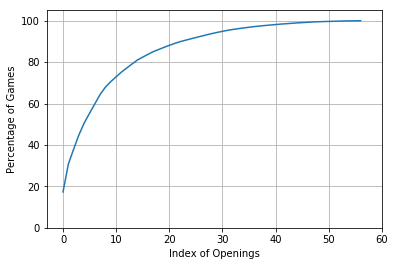

In [5]:
# cumulative frequency plot of openings
fig, axc = plt.subplots()

df1['%freq'] = df1['game_count'].apply(lambda x: 
                                       100*x/df1['game_count'].sum())
print(f"Top 15 games cover: {round(df1.head(15)['%freq'].sum(),2)}")
df1.reset_index()['%freq'].cumsum().plot(grid=True, ylim=(0,105), 
                                         xlim=(-3,60), ax=axc)
axc.set_xlabel('Index of Openings')
axc.set_ylabel('Percentage of Games')
print(f'\nTop 15 most used openings (and their variations) cover more '
      'than 80% of his games')

# do groupby(Opening) count number of games per opening and sort values
# do normalization on the game column then plot cumsum

Top 15 most used openings.


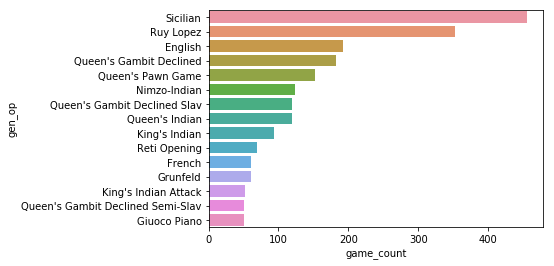

In [6]:
print(f'Top 15 most used openings.')
sns.barplot(df1.iloc[0:15]['game_count'], df1.iloc[0:15]['gen_op']);

# do get top 15 games via SQL query

#### Favored Opening Game: So

Looking at all the games played by Wesley So, he used 52 unique openings (not counting variations). The cells below extract the top opening games used by So, as recorded in the database.

Note that the data being considered does not take into account the results of the match.

In [7]:
# Opening Frequency of Usage
uniq_o = cursorObj.execute(
    '''SELECT gen_op, COUNT(Game) AS game_count FROM so GROUP BY gen_op 
    ORDER BY game_count DESC ''')
    
colnames = [tup[0] for tup in uniq_o.description]
df2 = pd.DataFrame(uniq_o, columns=colnames)
display(df2.head())

# number of unique openings
cnt_op = df2['gen_op'].nunique()
print(f'Number of Unique Openings (not counting variations): {cnt_op}')

,gen_op,game_count
0,Sicilian,176
1,Ruy Lopez,148
2,English,141
3,Queen's Gambit Declined,116
4,Queen's Pawn Game,81


Number of Unique Openings (not counting variations): 52


Top 15 games cover: 82.71

Top 15 most used openings (and their variations) cover more than 80% of his games


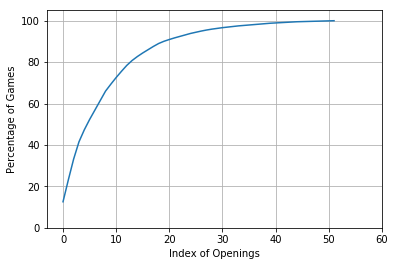

In [8]:
# cumulative frequency plot of openings
fig, axc = plt.subplots()

df2['%freq'] = df2['game_count'].apply(lambda x: 
                                       100*x/df2['game_count'].sum())
print(f"Top 15 games cover: {round(df2.head(15)['%freq'].sum(),2)}")
df2.reset_index()['%freq'].cumsum().plot(grid=True, ylim=(0,105), 
                                         xlim=(-3,60), ax=axc)
axc.set_xlabel('Index of Openings')
axc.set_ylabel('Percentage of Games')
print(f'\nTop 15 most used openings (and their variations) cover more '
      'than 80% of his games')

# do groupby(Opening) count number of games per opening and sort values
# do normalization on the game column then plot cumsum

Top 15 most used openings.


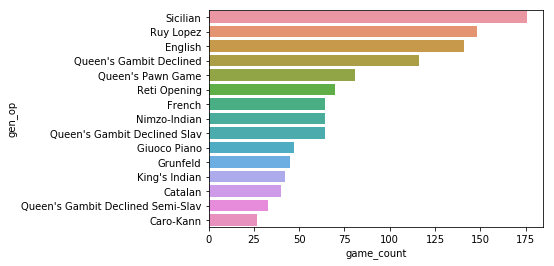

In [9]:
print(f'Top 15 most used openings.')
sns.barplot(df2.iloc[0:15]['game_count'], df2.iloc[0:15]['gen_op']);

# do get top 15 games via SQL query

#### Winning Strategies of Carlsen and So

We are now going to explore the features of the games won by each player, based on the data extracted from http://www.chessgames.com. Some features we are going to explore include the openings he used, the number of moves it takes for him to win, and whether he played as White or Black.

First, we look at the top winning openings of Carlsen in the cell below.

In [10]:
# Filter wins, groupby Openings then count number of games
# Concatenate with games count table then compute for the win-lose ratio
player = cursorObj.execute(
    '''SELECT * FROM carlsen''')

colnames = [tup[0] for tup in player.description]
df_carl = pd.DataFrame(player, columns=colnames)
df_carl['Result'] = df_carl['Result'].apply(lambda x: x.split('-')[1])

df_p = df_carl.groupby(['Result','gen_op'])['Game'].count()
df_p = df_p.loc['win'].reset_index()

df_rat = df1.merge(df_p, on='gen_op')
df_rat['win_ratio'] = 100*df_rat['Game']/df_rat['game_count']
df_rat.columns = ['Opening', 'Num_Games', 'Per_Freq', 'Wins', 'Win_Ratio']
df_rat = df_rat[df_rat['Num_Games']>=50]
df_rat = df_rat.sort_values('Win_Ratio', ascending=False)
df_rat

,Opening,Num_Games,Per_Freq,Wins,Win_Ratio
4,Queen's Pawn Game,152,5.770691,86,56.578947
12,King's Indian Attack,52,1.974184,29,55.769231
10,French,61,2.315869,33,54.098361
9,Reti Opening,69,2.619590,36,52.173913
8,King's Indian,93,3.530752,45,48.387097
6,Queen's Gambit Declined Slav,120,4.555809,56,46.666667
0,Sicilian,456,17.312073,208,45.614035
13,Queen's Gambit Declined Semi-Slav,51,1.936219,22,43.137255
7,Queen's Indian,120,4.555809,51,42.500000
3,Queen's Gambit Declined,182,6.909643,76,41.758242


We subdivide the data further, and try to see if Carlsen uses different strategies when playing as White and when playing as Black.

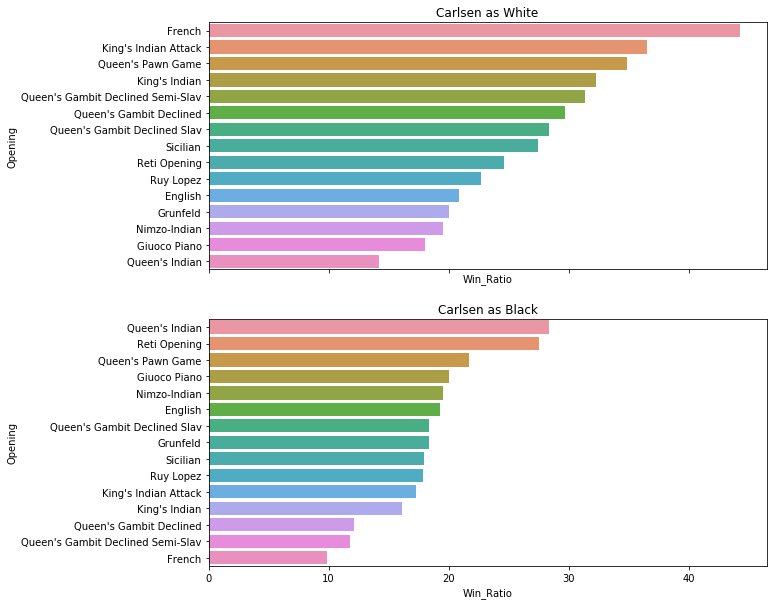

In [11]:
fig, ax = plt.subplots(2,1, sharex=True)
fig.set_size_inches(10,10)

df_whitec = df_carl[df_carl['White'].apply(lambda x: x.strip())=='Carlsen']

df_p = df_whitec.groupby(['Result','gen_op'])['Game'].count()
df_p = df_p.loc['win'].reset_index()

df_rat = df1.merge(df_p, on='gen_op')
df_rat['win_ratio'] = 100*df_rat['Game']/df_rat['game_count']
df_rat.columns = ['Opening', 'Num_Games', 'Per_Freq', 'Wins', 'Win_Ratio']
df_rat = df_rat[df_rat['Num_Games']>=50]
df_rat = df_rat.sort_values('Win_Ratio', ascending=False)
sns.barplot(df_rat['Win_Ratio'],df_rat['Opening'], ax=ax[0])
ax[0].set_title('Carlsen as White');

df_blackc = df_carl[df_carl['Black'].apply(lambda x: x.strip())=='Carlsen']
df_p = df_blackc.groupby(['Result','gen_op'])['Game'].count()
df_p = df_p.loc['win'].reset_index()

df_rat = df1.merge(df_p, on='gen_op')
df_rat['win_ratio'] = 100*df_rat['Game']/df_rat['game_count']
df_rat.columns = ['Opening', 'Num_Games', 'Per_Freq', 'Wins', 'Win_Ratio']
df_rat = df_rat[df_rat['Num_Games']>=50]
df_rat = df_rat.sort_values('Win_Ratio', ascending=False)
sns.barplot(df_rat['Win_Ratio'],df_rat['Opening'], ax=ax[1])
ax[1].set_title('Carlsen as Black');

What is interesting about Carlsen's play style is the fact that he uses different openings when he plays as White and when he plays as Black. The plot also indicates that he wins mostly when he is playing as White.

Next, we look at the top winning openings of So in the cell below.

In [12]:
# Filter wins, groupby Openings then count number of games
# Concatenate with games count table then compute for the win-lose ratio
player = cursorObj.execute(
    '''SELECT * FROM so''')

colnames = [tup[0] for tup in player.description]
df_so = pd.DataFrame(player, columns=colnames)
df_so['Result'] = df_so['Result'].apply(lambda x: x.split('-')[1])
# display(df_so)
df_p = df_so.groupby(['Result','gen_op'])['Game'].count()
df_p = df_p.loc['win'].reset_index()

df_rat = df1.merge(df_p, on='gen_op')
df_rat['win_ratio'] = 100*df_rat['Game']/df_rat['game_count']
df_rat.columns = ['Opening', 'Num_Games', 'Per_Freq', 'Wins', 'Win_Ratio']
df_rat = df_rat[df_rat['Num_Games']>=50]
df_rat = df_rat.sort_values('Win_Ratio', ascending=False)
df_rat

,Opening,Num_Games,Per_Freq,Wins,Win_Ratio
10,French,61,2.315869,30,49.180328
9,Reti Opening,69,2.619590,20,28.985507
2,English,192,7.289294,53,27.604167
11,Grunfeld,60,2.277904,15,25.000000
13,Queen's Gambit Declined Semi-Slav,51,1.936219,12,23.529412
12,King's Indian Attack,52,1.974184,12,23.076923
8,King's Indian,93,3.530752,21,22.580645
14,Giuoco Piano,50,1.898254,11,22.000000
4,Queen's Pawn Game,152,5.770691,29,19.078947
6,Queen's Gambit Declined Slav,120,4.555809,21,17.500000


Similarly, we subdivide the data and see if So uses different strategies when playing as White and when playing as Black.

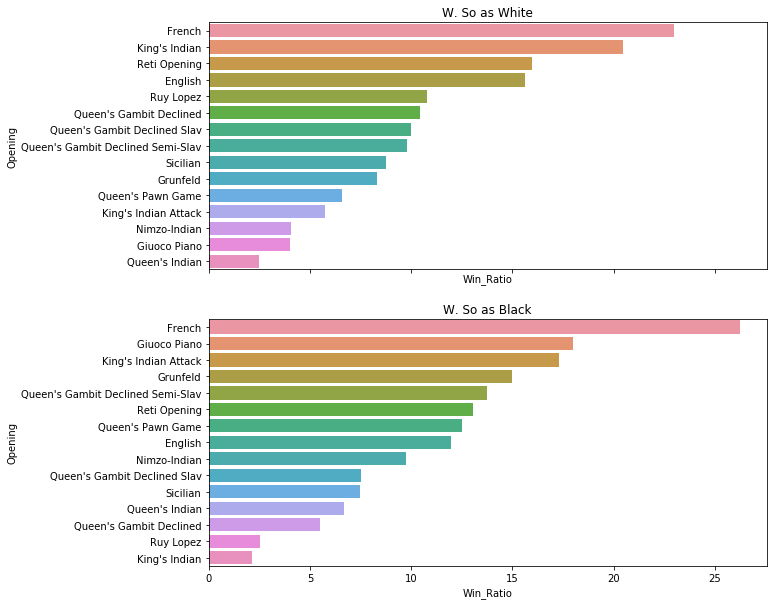

In [13]:
fig, ax = plt.subplots(2,1, sharex=True)
fig.set_size_inches(10,10)

df_whitec = df_so[df_so['White'].apply(lambda x: x.strip())=='W So']

df_p = df_whitec.groupby(['Result','gen_op'])['Game'].count()
df_p = df_p.loc['win'].reset_index()

df_rat = df1.merge(df_p, on='gen_op')
df_rat['win_ratio'] = 100*df_rat['Game']/df_rat['game_count']
df_rat.columns = ['Opening', 'Num_Games', 'Per_Freq', 'Wins', 'Win_Ratio']
df_rat = df_rat[df_rat['Num_Games']>=50]
df_rat = df_rat.sort_values('Win_Ratio', ascending=False)
sns.barplot(df_rat['Win_Ratio'],df_rat['Opening'], ax=ax[0])
ax[0].set_title('W. So as White');

df_blackc = df_so[df_so['Black'].apply(lambda x: x.strip())=='W So']
df_p = df_blackc.groupby(['Result','gen_op'])['Game'].count()
df_p = df_p.loc['win'].reset_index()

df_rat = df1.merge(df_p, on='gen_op')
df_rat['win_ratio'] = 100*df_rat['Game']/df_rat['game_count']
df_rat.columns = ['Opening', 'Num_Games', 'Per_Freq', 'Wins', 'Win_Ratio']
df_rat = df_rat[df_rat['Num_Games']>=50]
df_rat = df_rat.sort_values('Win_Ratio', ascending=False)
sns.barplot(df_rat['Win_Ratio'],df_rat['Opening'], ax=ax[1])
ax[1].set_title('W. So as Black');

It appears that So plays strongly using the French opening, especially when he is playing Black. Unlike Carlsen, So is using more or less the same openings as White or Black.

We now look at the number of moves that both players made when they win, lose, or draw a match. The cells below are used to create a boxplot of their own matches side-by-side.

In [14]:
def color_carl(x):
    if x == 'Carlsen':
        return 'white'
    else:
        return 'black'

def color_so(x):
    if x == 'W So':
        return 'white'
    else:
        return 'black'

df_carl['Carl_Color'] = df_carl['White'].apply(lambda x: color_carl(
    x.strip()))
df_so['So_Color'] = df_so['White'].apply(lambda x: color_so(x.strip()))

figb, axb = plt.subplots(1,2, sharey=True)
figb.set_size_inches(16,10)
plt.close()

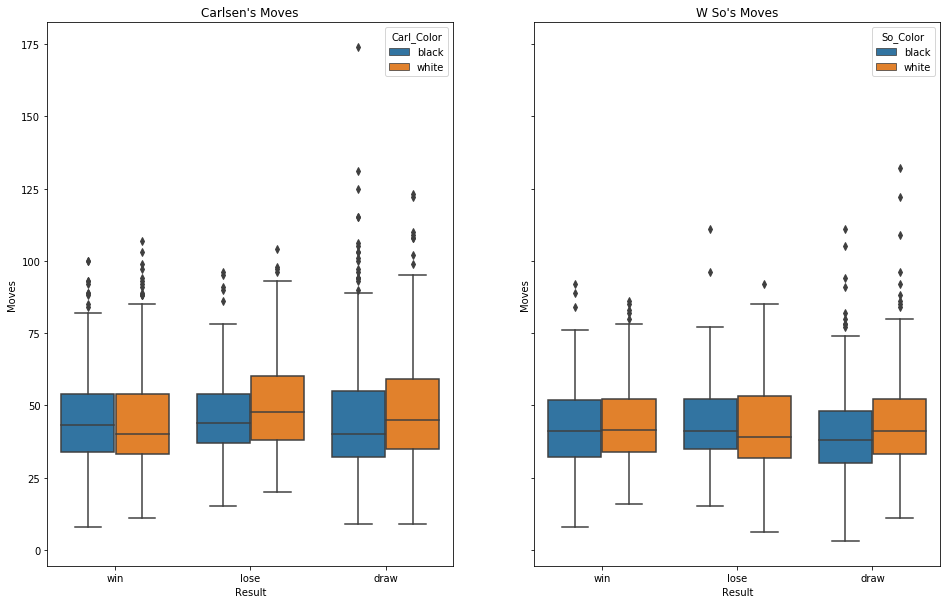

In [15]:
df_carl["Moves"] = pd.to_numeric(df_carl["Moves"])
sns.catplot(data=df_carl, x='Result', y='Moves', hue='Carl_Color', 
            kind='box', ax=axb[0], hue_order=['black','white'])
axb[0].set_title("Carlsen's Moves");
plt.close()

df_so["Moves"] = pd.to_numeric(df_so["Moves"])
sns.catplot(data=df_so, x='Result', y='Moves', hue='So_Color', kind='box', 
            ax=axb[1], hue_order=['black','white'])
axb[1].set_title("W So's Moves")
plt.close()
display(figb)

So finishes his games at roughly 40 moves (on average), but we see a lot of outliers when the game results in a draw. In contrast, Carlsen tends to extend the game when he is not winning. Note that one particular outlier in Carlsen's plot where he drew the game after 175 moves.

#### So vs Carlsen Matches

We are only considering the games they played against each other from 2015 onwards. The cell below displays the results of So when he is facing Carlsen in a match. So far, So has only won 7 games (out of 67) against Carlsen.

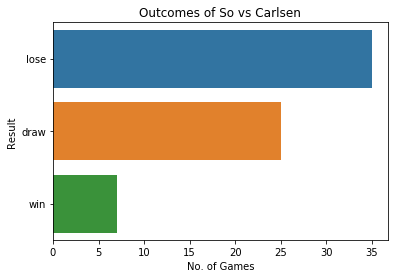

In [16]:
# Count the number of wins, draws and losses So had against Carlsen
sow = cursorObj.execute("SELECT * FROM versus WHERE Result LIKE '%-win'")
sow_l = sow.fetchall()
w = len(sow_l)
sod = cursorObj.execute("SELECT * FROM versus WHERE Result LIKE '%-draw'")
sod_l = sow.fetchall()
d = len(sod_l)
sol = cursorObj.execute("SELECT * FROM versus WHERE Result LIKE '%-lose'")
sol_l = sow.fetchall()
l = len(sol_l)

# Plot
fig, axwl = plt.subplots()
sns.barplot([l,d,w], ['lose','draw','win'], ax=axwl)
axwl.set_xlabel('No. of Games');
axwl.set_ylabel('Result');
axwl.set_title('Outcomes of So vs Carlsen');

Let us look closely at the games won by So against Carlsen. Most of the matchups are in speed chess, and he only won once using the classical chess format.

In [17]:
so_white = df_so[(df_so['White'].apply(lambda x: x.strip())=='W So')&(df_so['Black'].apply(lambda x: x.strip())=='Carlsen')]
so_black = df_so[(df_so['Black'].apply(lambda x: x.strip())=='W So')&(df_so['White'].apply(lambda x: x.strip())=='Carlsen')]

df_svc = so_black.append(so_white)
df_svc.columns=['index', 'Game', 'So_Result', 'Moves', 'Year', 'Event/Locale', 'Opening',
       'From', 'White', 'Black', 'gen_op', 'So_Color']
df_svc = df_svc[df_svc['So_Result']=='win']
display(df_svc)

,index,Game,So_Result,Moves,Year,Event/Locale,Opening,From,White,Black,gen_op,So_Color
298,23,Carlsen vs W So,win,58,2016,Grand Chess Tour Paris Rapid,"C65 Ruy Lopez, Berlin Defense",SO,Carlsen,W So,Ruy Lopez,black
397,22,Carlsen vs W So,win,51,2017,Your Next Move (Rapid),"E53 Nimzo-Indian, 4.e3",SO,Carlsen,W So,Nimzo-Indian,black
403,3,Carlsen vs W So,win,40,2017,Chess.com Speed Chess Championship 2017/18,"B13 Caro-Kann, Exchange",SO,Carlsen,W So,Caro-Kann,black
405,5,Carlsen vs W So,win,22,2017,Chess.com Speed Chess Championship 2017/18,"B13 Caro-Kann, Exchange",SO,Carlsen,W So,Caro-Kann,black
404,4,W So vs Carlsen,win,61,2017,Chess.com Speed Chess Championship 2017/18,D05 Queen's Pawn Game,SO,W So,Carlsen,Queen's Pawn Game,white
406,6,W So vs Carlsen,win,32,2017,Chess.com Speed Chess Championship 2017/18,A04 Reti Opening,SO,W So,Carlsen,Reti Opening,white
411,11,W So vs Carlsen,win,44,2018,Altibox Norway,D10 Queen's Gambit Declined Slav,SO,W So,Carlsen,Queen's Gambit Declined Slav,white


So won against Carlsen 4 times as Black and 3 times as White. Note also that So avoided the strong openings of Carlsen, except for the Reti opening (where Carlsen wins around 30% of the time as Black).

## Conclusion

Both Carlsen and So have a wide array of opening moves in their arsenal, and they normally uses different strategies when playing as White and when playing as Black. In terms of opening, however, Carlsen uses a lot more variations as compared with So.

It is also interesting to note that for both players, the most used openings they are using (based on the database) is not exactly their strongest openings. They must be using chessgames.com to practice on the other openings that they are not very good at.

Another interesting observation is the fact that both players tend to extend the game when the end result is a draw.

This study only covered the opening moves made by Carlsen and So, which is a good material for novice chess players to study in order to improve their game. However, this is not enough to learn how they play the game. In fact, Carlsen admitted that he mostly concentrates on the middle game and not on the opening game. One must analyze the actual games of these two players in order to understand their nuances and plan a strategy to defeat them.

## References

* публикации, Время, "Magnus Carlsen: 'I Love the Middlegame, Because There You Get Pure Chess'," Chess-News, http://chess-news.ru/en/node/19178 (accessed June 7, 2019).
* CHESScom, "The English Opening: Chess Openings Explained", https://www.chess.com/article/view/english-opening-chess (accesses June 7, 2019).
* Cox, David, "Wesley So Interview: 'Chess Was A Way Out'," Chess.com, https://www.chess.com/article/view/wesley-so-interview-chess-was-a-way-out (accessed June 7, 2019).
* McGourty, Colin, "Tukmakov on this 'internet romance' coaching So," chess24, https://chess24.com/en/read/news/tukmakov-on-his-internet-romance-coaching-so (accessed June 7, 2019).
* Pandolfini, Bruce, "Chess Openings: Traps and Zaps", New York: Simon & Schuster Inc.,1989.
* Wikipedia contributors, "Chess," Wikipedia, The Free Encyclopedia, https://en.wikipedia.org/w/index.php?title=Chess&oldid=898383238 (accessed June 6, 2019).
* Wikipedia contributors, "Magnus Carlsen," Wikipedia, The Free Encyclopedia, https://en.wikipedia.org/w/index.php?title=Magnus_Carlsen&oldid=899446653 (accessed June 6, 2019).
* Wikipedia contributors, "Queen's Gambit Declined," Wikipedia, The Free Encyclopedia, https://en.wikipedia.org/w/index.php?title=Queen%27s_Gambit_Declined&oldid=851113931 (accessed June 7, 2019).
* Wikipedia contributors, "Sicilian Defence," Wikipedia, The Free Encyclopedia, https://en.wikipedia.org/w/index.php?title=Sicilian_Defence&oldid=897040921 (accessed June 7, 2019).
* Wikipedia contributors, "Wesley So," Wikipedia, The Free Encyclopedia, https://en.wikipedia.org/w/index.php?title=Wesley_So&oldid=900349974 (accessed June 6, 2019).